# Necessary Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data Input

In [3]:
# Dataset path
dataset_path = "/content/drive/MyDrive/utility/FinalYearProj(KMRT1S2)/Dataset"

# Paths for images and masks
images_path = os.path.join(dataset_path, "Input/Images")
masks_path = os.path.join(dataset_path, "Input/Bmasks")

# Get list of files
images_files = os.listdir(images_path)
masks_files = os.listdir(masks_path)

# Create dataframes
images_df = pd.DataFrame({"image": images_files})
masks_df = pd.DataFrame({"mask": masks_files})

# Print sizes and heads
print("Images size:", len(images_df))
print("Masks size:", len(masks_df))

print("\nImages head:")
print(images_df.head(10))

print("\nMasks head:")
print(masks_df.head(10))


Images size: 50
Masks size: 50

Images head:
              image
0  ISIC_0024307.jpg
1  ISIC_0024309.jpg
2  ISIC_0024306.jpg
3  ISIC_0024308.jpg
4  ISIC_0024310.jpg
5  ISIC_0024321.jpg
6  ISIC_0024333.jpg
7  ISIC_0024336.jpg
8  ISIC_0024334.jpg
9  ISIC_0024311.jpg

Masks head:
                            mask
0  ISIC_0024307_segmentation.png
1  ISIC_0024310_segmentation.png
2  ISIC_0024309_segmentation.png
3  ISIC_0024308_segmentation.png
4  ISIC_0024306_segmentation.png
5  ISIC_0024340_segmentation.png
6  ISIC_0024332_segmentation.png
7  ISIC_0024355_segmentation.png
8  ISIC_0024354_segmentation.png
9  ISIC_0024337_segmentation.png


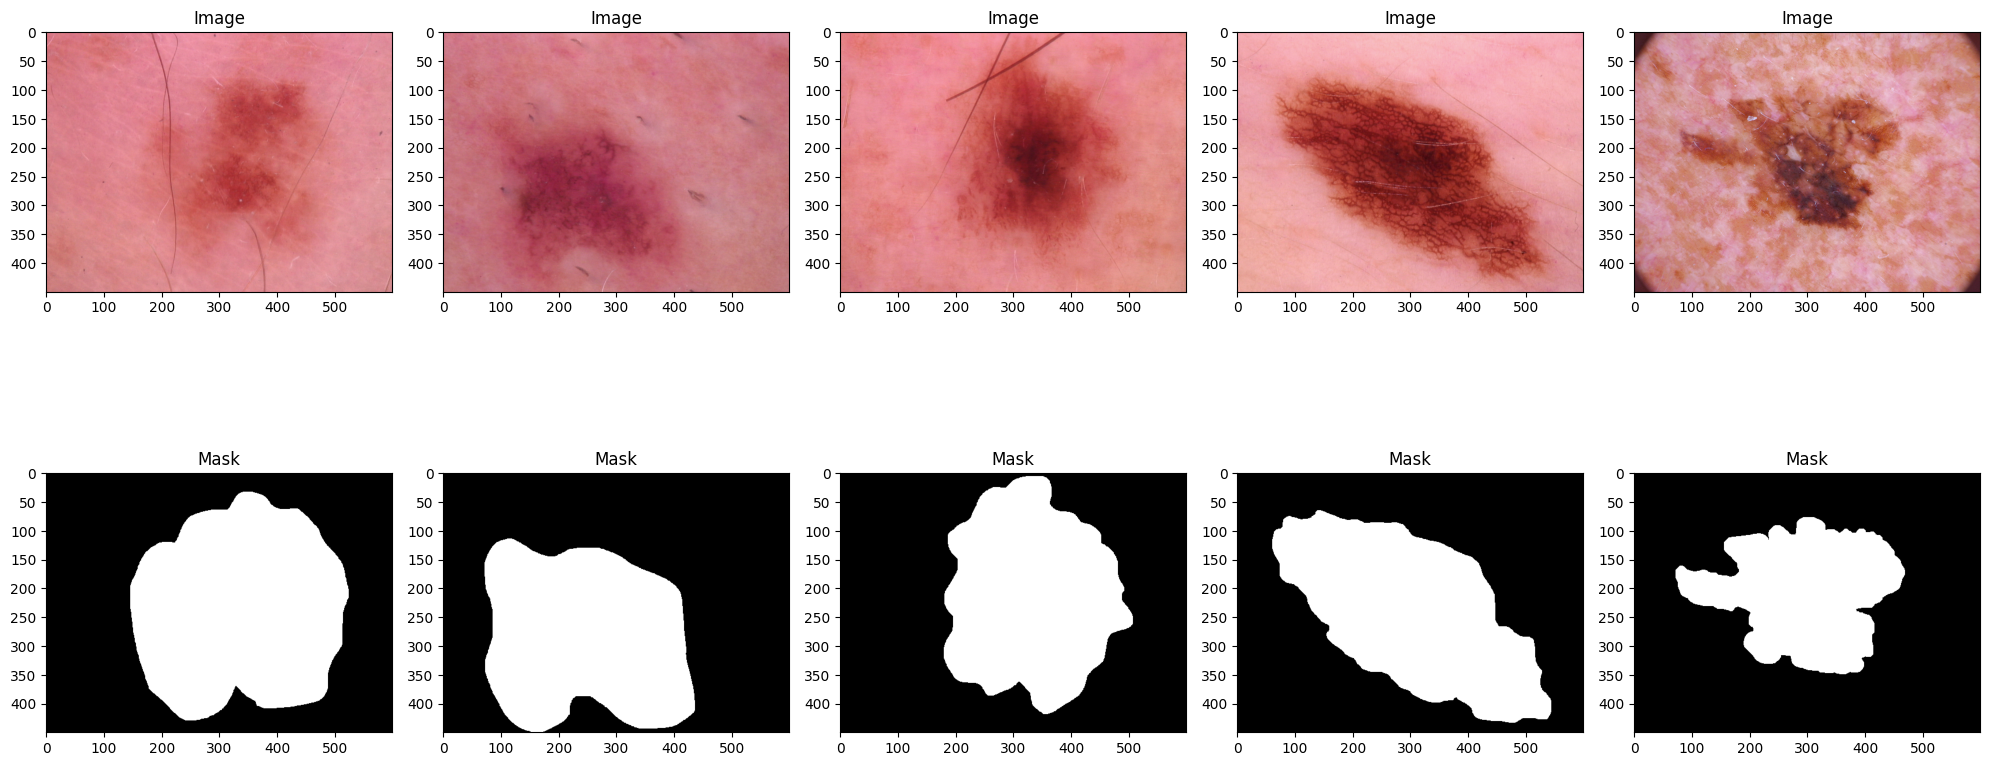

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display 5 images and their masks
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

for i in range(5):
    # Load image
    image_name = images_df.iloc[i]["image"]
    image_path = os.path.join(images_path, image_name)
    image = mpimg.imread(image_path)

    # Load mask
    mask_name = image_name.replace(".jpg", "_segmentation.png")
    mask_path = os.path.join(masks_path, mask_name)
    mask = mpimg.imread(mask_path)

    # Display image and mask
    axs[0, i].imshow(image)
    axs[0, i].axis('on')
    axs[0, i].set_title("Image")

    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].axis('on')
    axs[1, i].set_title("Mask")

plt.tight_layout()
plt.show()


# Resizing

In [5]:
# Resize images and masks to 416x416
new_size = (416, 416)

resized_images = []
resized_masks = []

for i in range(len(images_df)):
    # Load image
    image_name = images_df.iloc[i]["image"]
    image_path = os.path.join(images_path, image_name)
    image = cv2.imread(image_path)

    # Load mask
    mask_name = image_name.replace(".jpg", "_segmentation.png")
    mask_path = os.path.join(masks_path, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize image
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_LINEAR)

    # Resize mask
    resized_mask = cv2.resize(mask, new_size, interpolation=cv2.INTER_NEAREST)

    resized_images.append(resized_image)
    resized_masks.append(resized_mask)

# Convert resized images and masks to numpy arrays
resized_images = np.array(resized_images)
resized_masks = np.array(resized_masks)

print("Resized images shape:", resized_images.shape)
print("Resized masks shape:", resized_masks.shape)


Resized images shape: (50, 416, 416, 3)
Resized masks shape: (50, 416, 416)


In [6]:
def swap_rgb(image):
    return image[:, :, ::-1]

In [7]:
def RGBimshow(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)

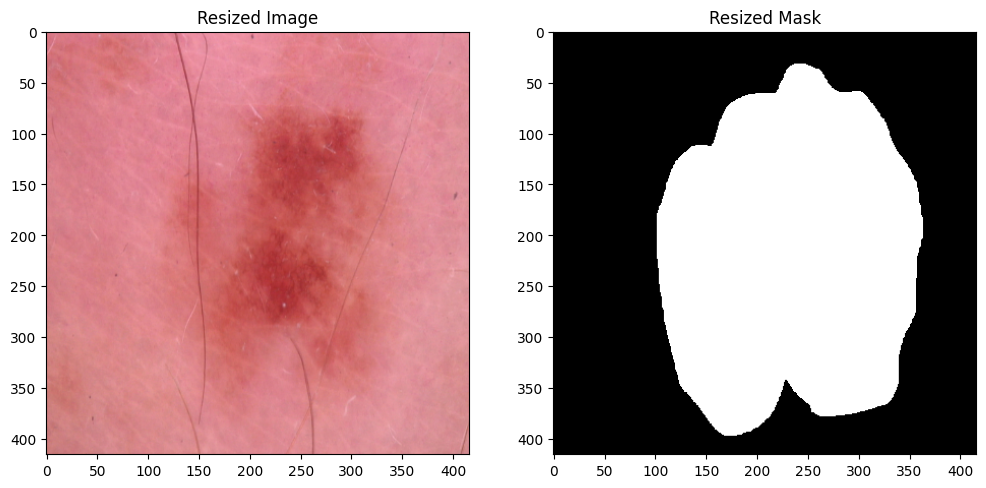

In [8]:
# Choose an index for the image
index = 0

# Plot the resized image and its mask
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot resized image
axs[0].imshow(swap_rgb(resized_images[index]))
axs[0].axis('on')
axs[0].set_title('Resized Image')

# Plot resized mask
axs[1].imshow(resized_masks[index], cmap='gray')
axs[1].axis('on')
axs[1].set_title('Resized Mask')

plt.show()

In [9]:
# Get the new width and height
new_height, new_width = resized_images[index].shape[:2]

# Print the new size
print(f"Resized Image Size - Width: {new_width}, Height: {new_height}")


Resized Image Size - Width: 416, Height: 416


# Coco Json Creation

In [10]:
# Label ids of the dataset
category_ids = {
    "non": 0,
    "affected": 1,
}

# Define which colors match which categories in the images
category_colors = {
    "(0, 0, 0)": 0, # normal
    "(255, 255, 255)": 1, # affected
}

# Define the ids that are a multipolygon.
multipolygon_ids = [1]

In [11]:
# Get "images" and "annotations" info
def images_annotations_info(maskpath):
    # This id will be automatically increased as we go
    annotation_id = 0
    image_id = 0
    annotations = []
    images = []

    for mask_image in glob.glob(maskpath + "*.png"):
        # The mask image is *.png but the original image is *.jpg.

        original_file_name = os.path.basename(mask_image).split("_segmentation.")[0] + ".jpg"

        # Open the image and (to be sure) we convert it to RGB
        mask_image_open = Image.open(mask_image).convert("RGB")
        w, h = mask_image_open.size

        # "images" info
        image = create_image_annotation(original_file_name, w, h, image_id)
        images.append(image)

        sub_masks = create_sub_masks(mask_image_open, w, h)
        has_class_1 = False
        for color, sub_mask in sub_masks.items():
            category_id = category_colors[color]

            # "annotations" info
            polygons, segmentations = create_sub_mask_annotation(sub_mask)

            # Check if we have classes that are a multipolygon
            if category_id in multipolygon_ids:
                # Combine the polygons to calculate the bounding box and area
                multi_poly = MultiPolygon(polygons)

                annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
            else:
                for i in range(len(polygons)):
                    # Cleaner to recalculate this variable
                    segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]

                    annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)

                    annotations.append(annotation)
                    annotation_id += 1
                    if category_id == 1:
                        has_class_1 = True
        if not has_class_1:
            # Add a background annotation for the entire image
            annotation = create_annotation_format(Polygon([(0, 0), (w, 0), (w, h), (0, h)]), [[0, 0, w, 0, w, h, 0, h]], image_id, 0, annotation_id)
            annotations.append(annotation)
            annotation_id += 1

        image_id += 1
    return images, annotations, annotation_id



In [14]:
if _name_ == "_main_":
    # Get the standard COCO JSON format
    coco_format = get_coco_json_format()

    for keyword in ["input_images"]:
        mask_path = "dataset/{}_mask/".format(keyword)

        # Create category section
        coco_format["categories"] = create_category_annotation(category_ids)

        # Create images and annotations sections
        coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

        output_dir = "dataset/output/"
        os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

        with open(os.path.join(output_dir, "{}.json".format(keyword)), "w") as outfile:
            json.dump(coco_format, outfile)

NameError: name '_name_' is not defined

In [ ]:
mask_image_open = Image.open(mask_image).convert("RGB")w,